# Creating the model

In [20]:
# Using best Hyperparameters
window_size = 10
lstm_units = [100, 100]
dense_units = [50]
dropout = 0

epochs = 25
batch_size = 8
set_early_stopping = True

In [21]:
# Imports
import pandas as pd
import numpy as np
import ml_utils as mlu
import warnings
warnings.filterwarnings('ignore')

In [22]:
# Loading Dataset
df = pd.read_csv("datasets/apple_2014-2024_fullSimpleFeatures.csv")
df = df.set_index(['date'])
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df = df.dropna()

In [23]:
# Completing the dates
df = df.reindex(pd.date_range(start=df.index.min(),
                              end=df.index.max(),
                              freq='D'))
df = df.fillna(method='ffill')
df['week_day'] = df.index.day_name()
df['week_day_num'] = df.index.dayofweek
df['weekday_sin'] = np.sin(2 * np.pi * df['week_day_num'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['week_day_num'] / 7)
#df.head(10)

In [24]:
# Selecting Features
target = df[['Close']]
input = df[['Close', 'weekday_sin', 'weekday_cos']]

# input = df[['last_close', 'RSI_14', 'SMA_5', 'SMA_10', 'SMA_20',
#        'SMA_50', 'SMA_100', 'EMA_20', 'EMA_50', 'EMA_100', 'MACD',
#        'MACD_Signal', 'BBU_20_2.0', 'BBL_20_2.0', 'momentum_10', 'ATR_14', 'week_day_num']]

Epoch 1/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0164 - val_loss: 0.0034
Epoch 2/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 7.9266e-04 - val_loss: 0.0188
Epoch 3/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 7.2439e-04 - val_loss: 0.0020
Epoch 4/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0010 - val_loss: 0.0044
Epoch 5/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 7.4870e-04 - val_loss: 0.0023
Epoch 6/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 4.7212e-04 - val_loss: 0.0022
Epoch 7/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.4214e-04 - val_loss: 0.0029
Epoch 8/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5330e-04 - val_loss: 0.0013
Epoch 9/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0951e-04 - val_loss: 6.2532e-04
Epoch 10/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2.9481e-04 - val_loss: 0.0020
Epoch 11/25
374/374 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 4.6511e-04 - val_loss: 4.8388e-04
Epoch 1

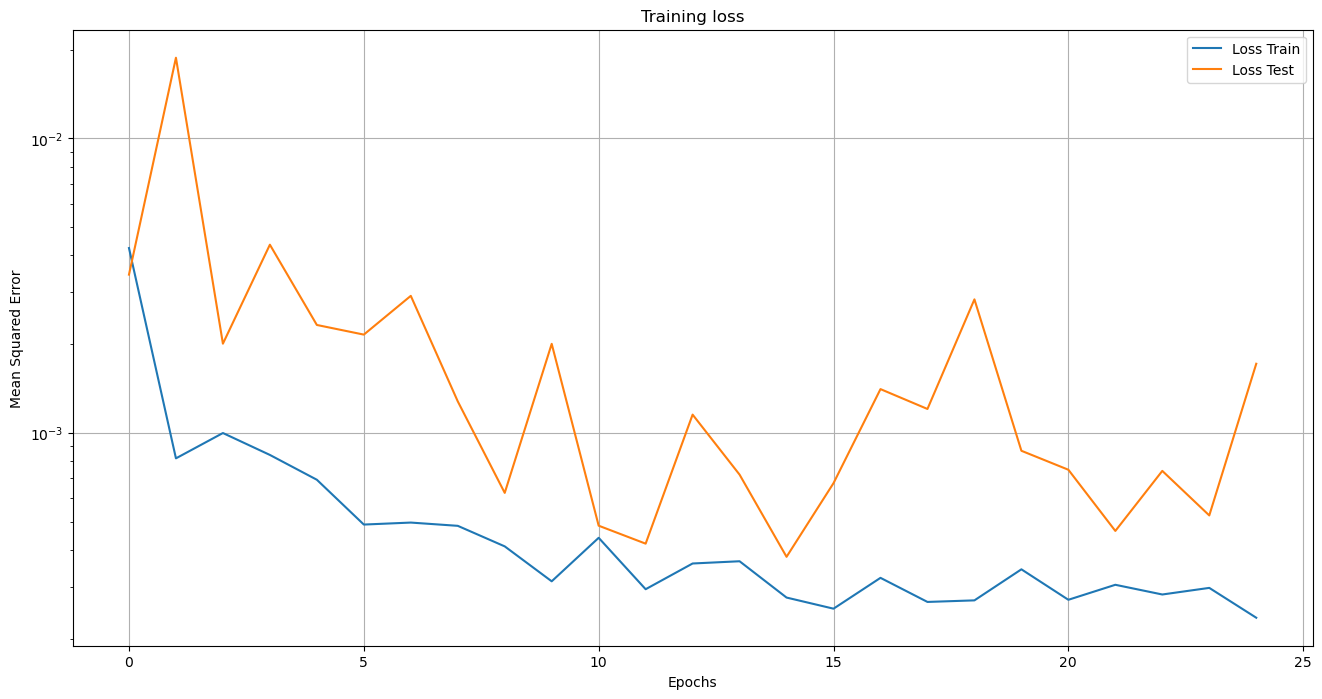

Train-Set Score
MAE: 2.5003
RMSE: 3.9490
MAPE (%): 3.3505
DA: 34.9732
R²: 0.9934

Test-Set Score
MAE: 1.6278
RMSE: 2.2472
MAPE (%): 0.8816
DA: 35.2075
R²: 0.9940


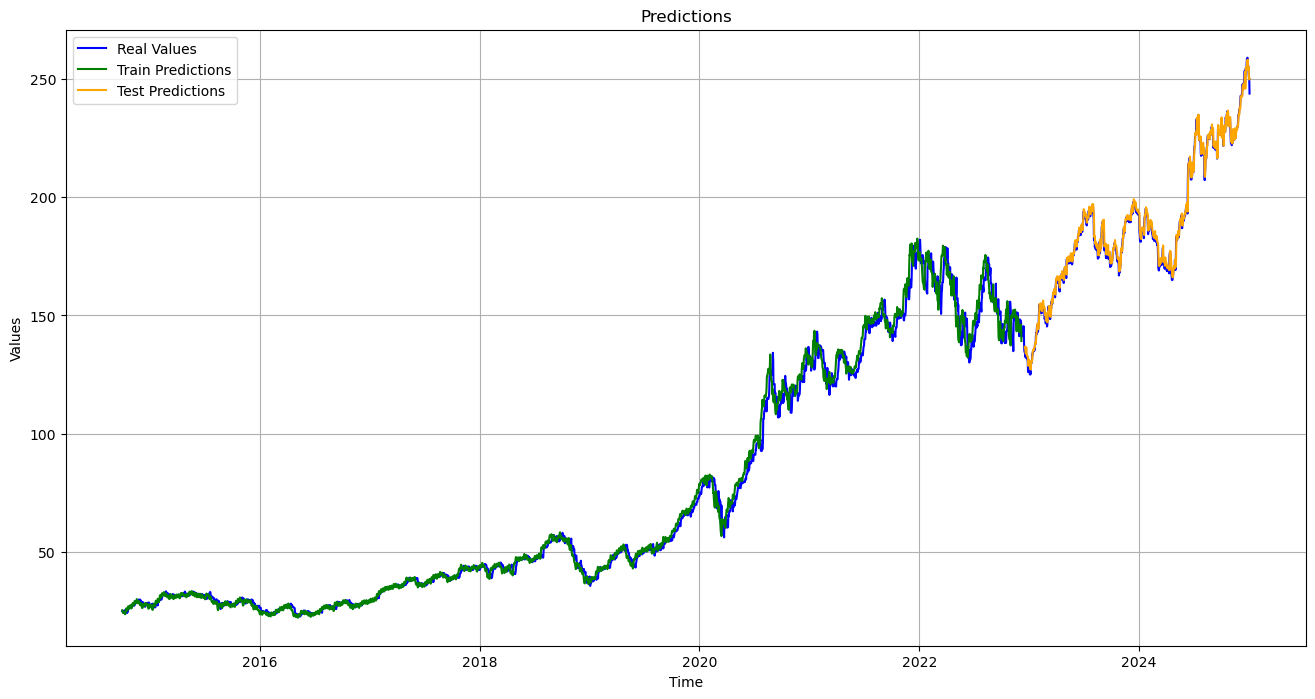

In [25]:
# Preparing Data
to_ignore = []
#to_ignore = ['weekday_sin', 'weekday_cos']

data_scaler = mlu.Data_Robust_Scaler(input, target, features_to_ignore=to_ignore)
scaled_input, scaled_target = data_scaler.get_scaled_data()
X_train, X_test, y_train, y_test, input_size, train_size = mlu.train_test_split_timeWindows(scaled_input,
                                                                                            scaled_target,
                                                                                            window_size=window_size,
                                                                                            train_size_pct=0.8)

# Creating Model
model2 = mlu.LSTMModel(input_shape=input_size,
                       lstm_units=lstm_units,
                       dense_units=dense_units,
                       dropout=dropout)

# Training Model
model2.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    set_early_stopping=set_early_stopping,
    validation_data=(X_test, y_test)
)

# Making Predictions
y_train_pred = model2.predict(X_train)
y_test_pred = model2.predict(X_test)

# Printing Results
model2.plot_loss()
data_scaler.get_dataframe_results(y_train_pred, y_test_pred, train_size, window_size=window_size)
data_scaler.print_scores()
data_scaler.plot_results()

## Directional Accuracy

In [ ]:
test_results = data_scaler.test_results
#test_results

,Close,pred
2022-12-17,134.509995,136.707397
2022-12-18,134.509995,135.961578
2022-12-19,132.369995,135.611649
2022-12-20,132.300003,133.997955
2022-12-21,135.449997,133.831436
...,...,...
2024-12-29,255.589996,255.269257
2024-12-30,252.199997,255.125031
2024-12-31,250.419998,251.157959
2025-01-01,250.419998,249.820023


In [28]:
import matplotlib.pyplot as plt

def directional_accuracy(test_results, plot=True):
    true_diff = np.diff(test_results['Close'])
    pred_diff = np.diff(test_results['pred'])

    true_dir = np.sign(true_diff)
    pred_dir = np.sign(pred_diff)

    correct = np.sum(true_dir == pred_dir)
    total = len(true_dir)
    
    time_span = test_results.index[1:]
    
    if plot:
        plt.figure(figsize=(12, 4))
        plt.plot(time_span, true_dir, label='Real direction', marker='o')
        plt.plot(time_span, pred_dir, label='Predicted direction', marker='x')
        plt.title('Predicted direction vs Real direction')
        plt.xlabel('Index')
        plt.ylabel('Direction (-1 = ↓, 0 = =, 1 = ↑)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return correct / total * 100


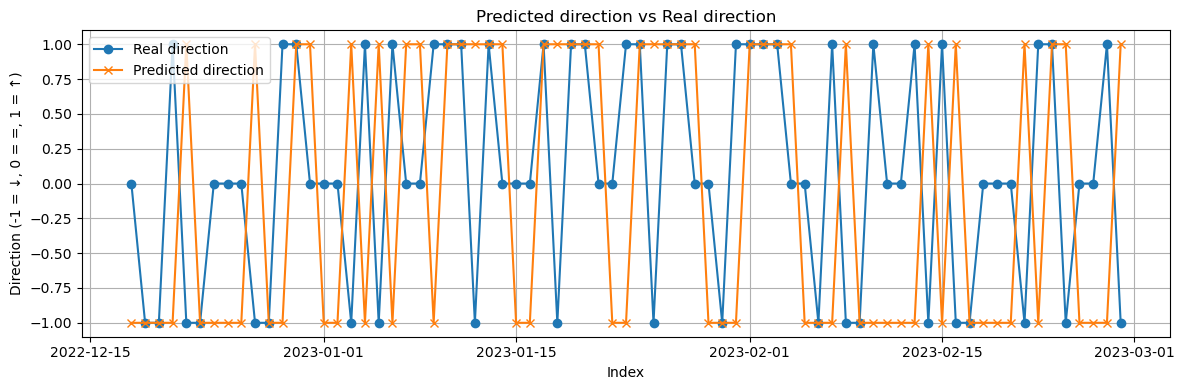

30.136986301369863

In [29]:
directional_accuracy(test_results.iloc[:int(len(test_results)*0.1)], plot=True)

# FORECASTS TESTS

In [26]:
# Preparing forecast dataframe
test_results = data_scaler.test_results
test_results['forecast'] = pd.NA
test_results

,Close,pred,forecast
2022-12-17,134.509995,137.995132,NaN
2022-12-18,134.509995,136.896332,NaN
2022-12-19,132.369995,135.869431,NaN
2022-12-20,132.300003,133.570541,NaN
2022-12-21,135.449997,133.705917,NaN
...,...,...,...
2024-12-29,255.589996,255.563293,NaN
2024-12-30,252.199997,252.899811,NaN
2024-12-31,250.419998,249.390793,NaN
2025-01-01,250.419998,248.386292,NaN


In [27]:
# Preparing forecast parameters
initial_window = X_test[0][:window_size].reshape(1, 10, 3)
forecast_window = len(test_results) - 1

In [28]:
def next_weekday_encoding(sin_val, cos_val):
    # Calcola l'angolo corrente (in radianti)
    angle = np.arctan2(sin_val, cos_val)
    # Incrementa l'angolo di 2π / 7 per passare al giorno successivo
    next_angle = angle + (2 * np.pi / 7)
    # Normalizza l'angolo tra -π e π
    next_angle = (next_angle + np.pi) % (2 * np.pi) - np.pi
    # Calcola la nuova coppia sin e cos
    next_sin = np.sin(next_angle)
    next_cos = np.cos(next_angle)
    return next_sin, next_cos

In [29]:
WEEKDAY_ENCODINGS = [
    (np.sin(2 * np.pi * i / 7), np.cos(2 * np.pi * i / 7))
    for i in range(7)
]

def next_weekday_encoding_by_lookup(sin_val, cos_val, tol=1e-8, encoding=WEEKDAY_ENCODINGS):
    for i, (s, c) in enumerate(encoding):
        if np.isclose(sin_val, s, atol=tol) and np.isclose(cos_val, c, atol=tol):
            next_index = (i + 1) % 7  # torna a lunedì dopo domenica
            return WEEKDAY_ENCODINGS[next_index]
    raise ValueError("Coppia (sin, cos) non riconosciuta come giorno valido.")

In [ ]:
def forecast_autoregressive_circularDayEncription(model, initial_window, n_steps):
    window = initial_window
    predictions = []

    for _ in range(n_steps):
        next_pred = model.predict(window)[0] #Single prediction
        #print(window[0][-1][1], window[0][-1][2])
        next_sin, next_cos = next_weekday_encoding_by_lookup(window[0][-1][1], window[0][-1][2])
        new_elem = [next_pred[0], next_sin, next_cos]
        # print(new_elem)
        # print(next_pred)
        # print(next_pred.shape)
        predictions.append(next_pred)
        
        temp = np.array(window[0][1:])
        # print(temp.shape)
        window[0] = np.append(temp, new_elem).reshape(temp.shape[0]+1, temp.shape[1])

    return np.array(predictions)

In [31]:
# Forecasting
forecast = forecast_autoregressive_circularDayEncription(model2, initial_window, forecast_window)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
-0.433883739117558 -0.9009688679024191
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
-0.9749279121818236 -0.2225209339563146
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
-0.7818314824680299 0.6234898018587334
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0.0 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0.7818314824680298 0.6234898018587336
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0.9749279121818236 -0.22252093395631434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0.43388373911755823 -0.900968867902419
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
-0.433883739117558 -0.9009688679024191
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
-0.9749279121818236 -0.2225209339563146
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
-0.7818314824680299 0.6234898018587334
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0.0 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0.7818314824680298 0.6234898018587336
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0.9749279121818236 -0.22252093395631434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
0.43388373911755823 

In [32]:
rescaled_forecast = data_scaler.inverse_scale_output(forecast)

In [33]:
test_results['forecast'].iloc[:len(rescaled_forecast)] = rescaled_forecast.reshape(len(rescaled_forecast),)

In [34]:
test_results

,Close,pred,forecast
2022-12-17,134.509995,137.995132,137.995132
2022-12-18,134.509995,136.896332,140.094421
2022-12-19,132.369995,135.869431,140.640747
2022-12-20,132.300003,133.570541,140.921707
2022-12-21,135.449997,133.705917,141.574463
...,...,...,...
2024-12-29,255.589996,255.563293,231.005859
2024-12-30,252.199997,252.899811,230.587448
2024-12-31,250.419998,249.390793,229.723267
2025-01-01,250.419998,248.386292,228.897949


In [35]:
mlu.model_scores(test_results['Close'].iloc[:20], test_results['forecast'].iloc[:20])

MAE: 18.2659
RMSE: 20.3972
MAPE (%): 14.1450
R²: -47.2014


{'MAE': 18.265942001342772,
 'RMSE': 20.397209888005474,
 'MAPE (%)': 14.145007008776203,
 'R²': -47.20142850212906}

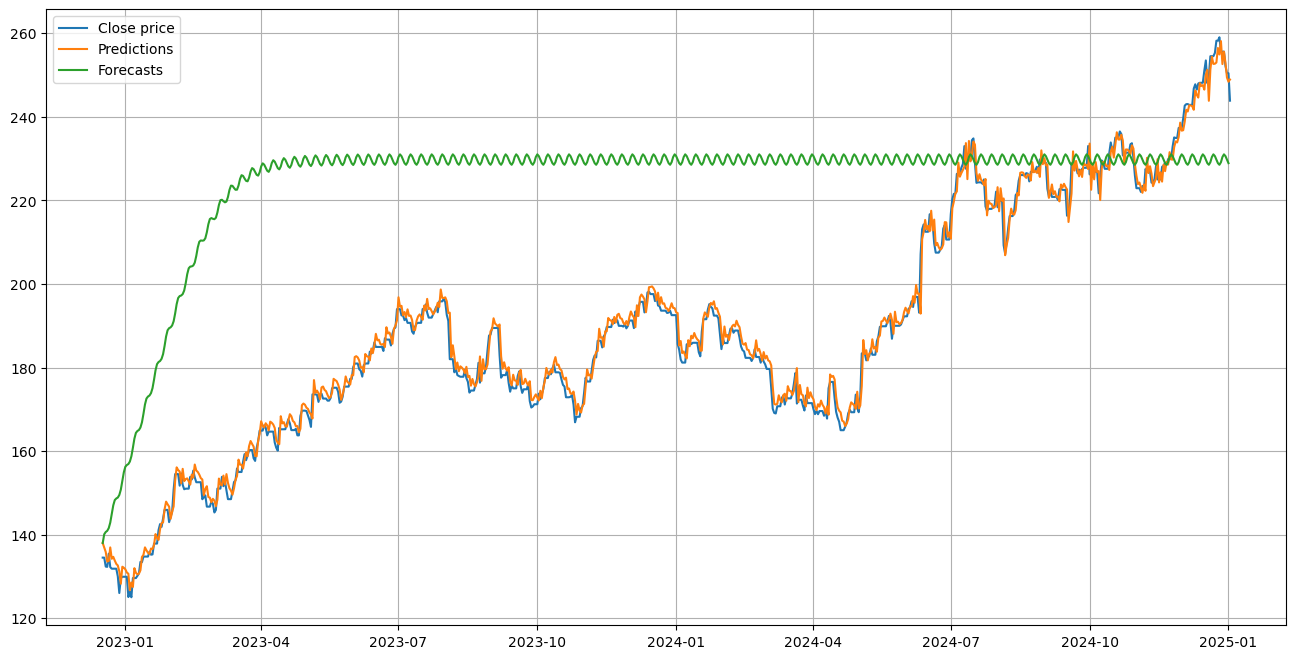

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(test_results['Close'], label='Close price')
plt.plot(test_results['pred'], label='Predictions')
plt.plot(test_results['forecast'][test_results['forecast'].notna()], label='Forecasts')
plt.grid(True)
plt.legend()
plt.show()